<h1 style="text-align: center;" markdown="1"><font color=green>Gentrified or not?</font> </h1>

<font color=green>** Gentrification **</font>   
The process of renovation of deteriorated urban neighborhoods by means of the influx of more affluent residents. 

<font color=green>**Why this project?**</font> 
1. Rich and open data sources
1. Socioeconomic impact
1. Useful tool for policy makers, residents, investors

<font color=green>** How I am going to tackle this problem **:</font> <br>
+ A machine learning model that captures current gentrification trend and predicts future. Signals will be used are:
    - ** housing **: % change house values, % rent, % renters etc
    - ** population **: income, %low-income, %high-income, high education, race etc
    - ** location and infrastructures **: safety, proximity to affluent neighborhoods, public transits, noval business
    - ** others **: taxi riders, social-network check-ins, news/twitter sentiment
+ A interactive tool that enables people to explore and understand gentrification better 

<h2 style="text-align: center;" markdown="1"><font color=black>This Notebook </font> </h2>


**Data used in this notebook:**
1. Zillow research data  
https://www.zillow.com/research/data/#bulk
1. Crime data from SF government https://data.sfgov.org
1. US Census ACS data fact finder
https://factfinder.census.gov/faces/nav/jsf/pages/guided_search.xhtml


<h2 style="text-align: center;" markdown="1">Import modules</h2>


In [398]:
import pandas as pd
import numpy as np
import time
import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
import shapefile
from matplotlib.collections import PatchCollection
from sodapy import Socrata
from descartes import PolygonPatch

# API
import requests
import json
from census import Census
from us import states

import statsmodels.api as sm
import matplotlib.pylab as plt
from pandas.tools.plotting import andrews_curves

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


<h2 style="text-align: center;" markdown="1"><font color=green>How we quantitatively define gentrification in mathmatical words?</font> </h2>

1. overall population <font color=red> ↑ </font> : low-income households <font color=red> ↓ 40% or more </font>
2. overall population <font color=red> ↓ </font> : the rate of low-income households <font color=red> ↓  40% or more </font>drastically than the overall population decline


> ## population and income data
Downloaded from US Census Bureau
https://factfinder.census.gov/faces/nav/jsf/pages/guided_search.xhtml

> American Community Survey: ACS, (2011-2015) 5 year survey, many separate files

In [399]:
# SF_zip code quried from googlemap
SF_zip =['94102', '94103', '94104', '94105', '94107', '94108', '94109', '94110', '94111', '94112', '94114', '94115', '94116', '94117', '94118', '94121', '94122', '94123', '94124', '94127', '94129', '94130', '94131', '94132', '94133', '94134', '94158']

filepath = '/Users/fangjie/Workspace/mockinterviews/Data_Incubator/data/'
# loadincome from S1902 
for year in ['11', '12','13','14','15']:
    name = 'df_income_'+ year
    vars()[name] = pd.read_csv(filepath+'ACS_'+year+'_5YR_S1902/ACS_'+year+'_5YR_S1902_with_ann.csv')
    # select SF data (GEO.id2 zipcodes)
    vars()[name+'_SF']= vars()[name][vars()[name]['GEO.id2'].astype(str).isin(SF_zip)]
    
    # rename relevant columns
   # vars()[name+'_SF'] = vars()[name+'_SF'].rename(columns = {'HC01_EST_VC02':'total_household_'+year})
    vars()[name+'_SF'] = vars()[name+'_SF'].rename(columns = {'HC02_EST_VC02':'mean_'+year})
    
    ## load S1901
    name = 'df_pop_'+ year
    vars()[name] = pd.read_csv(filepath+'ACS_'+year+'_5YR_S1901/ACS_'+year+'_5YR_S1901_with_ann.csv')
    # select SF data (GEO.id2 zipcodes)
    vars()[name+'_SF']= vars()[name][vars()[name]['GEO.id2'].astype(str).isin(SF_zip)]
    # rename relevant columns
    vars()[name+'_SF'] = vars()[name+'_SF'].rename(columns = {'HC01_EST_VC01':'total_household_'+year})
    

> data checking

In [400]:
df_pop_11_SF.head()

,GEO.id,GEO.id2,GEO.display-label,total_household_11,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,...,HC04_EST_VC19,HC04_MOE_VC19,HC01_EST_VC20,HC01_MOE_VC20,HC02_EST_VC20,HC02_MOE_VC20,HC03_EST_VC20,HC03_MOE_VC20,HC04_EST_VC20,HC04_MOE_VC20
972,8600000US94102,94102,ZCTA5 94102,14884,591,3013,367,1867,293,11871,...,(X),(X),(X),(X),(X),(X),(X),(X),24.0,(X)
973,8600000US94103,94103,ZCTA5 94103,11230,505,3194,411,1996,309,8036,...,(X),(X),(X),(X),(X),(X),(X),(X),27.0,(X)
974,8600000US94104,94104,ZCTA5 94104,189,73,26,42,10,26,163,...,(X),(X),(X),(X),(X),(X),(X),(X),22.7,(X)
975,8600000US94105,94105,ZCTA5 94105,2769,349,875,211,799,204,1894,...,(X),(X),(X),(X),(X),(X),(X),(X),22.2,(X)
976,8600000US94107,94107,ZCTA5 94107,13028,504,5378,482,3893,381,7650,...,(X),(X),(X),(X),(X),(X),(X),(X),15.1,(X)


In [401]:
df_pop_15_SF.head()

,GEO.id,GEO.id2,GEO.display-label,total_household_15,HC01_MOE_VC01,HC02_EST_VC01,HC02_MOE_VC01,HC03_EST_VC01,HC03_MOE_VC01,HC04_EST_VC01,...,HC04_EST_VC19,HC04_MOE_VC19,HC01_EST_VC20,HC01_MOE_VC20,HC02_EST_VC20,HC02_MOE_VC20,HC03_EST_VC20,HC03_MOE_VC20,HC04_EST_VC20,HC04_MOE_VC20
973,8600000US94102,94102,ZCTA5 94102,16463,631,4149,457,2676,357,12314,...,(X),(X),(X),(X),(X),(X),(X),(X),20.1,(X)
974,8600000US94103,94103,ZCTA5 94103,12728,514,3568,442,2321,407,9160,...,(X),(X),(X),(X),(X),(X),(X),(X),24.1,(X)
975,8600000US94104,94104,ZCTA5 94104,176,48,74,32,56,34,102,...,(X),(X),(X),(X),(X),(X),(X),(X),20.6,(X)
976,8600000US94105,94105,ZCTA5 94105,3778,482,1253,392,1132,368,2525,...,(X),(X),(X),(X),(X),(X),(X),(X),17.8,(X)
977,8600000US94107,94107,ZCTA5 94107,13743,682,6066,499,4797,492,7677,...,(X),(X),(X),(X),(X),(X),(X),(X),18.7,(X)


In [402]:
df_income_15_SF.shape  # 11-15

(27, 111)

> calculate mean income each year

In [403]:
## the data from all years have the same structure, 27 zipcodes
# create new table with mean income from 2011-2015, zipcode, year, mean_income
#df_income = pd.merge(df_income_11_SF[['GEO.id2','HC02_EST_VC02']], 
#                     df_income_12_SF[['GEO.id2','HC02_EST_VC02']], 
#                     on='GEO.id2', suffixes = ['_2011', '_2012']
#                           )
dfs = [df_income_11_SF[['GEO.id2','mean_11']], df_income_12_SF[['GEO.id2','mean_12']], df_income_13_SF[['GEO.id2','mean_13']], df_income_14_SF[['GEO.id2','mean_14']],df_income_15_SF[['GEO.id2','mean_15']]]
#dfs = [df_income_11_SF[['GEO.id2','HC02_EST_VC02']], df_income_12_SF[['GEO.id2','HC02_EST_VC02']]]
df_income = reduce(lambda left,right: pd.merge(left,right,on='GEO.id2'), dfs)
df_income.head()

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15
0,94102,45260,48334,48910,54084,56397
1,94103,69089,73372,77913,77778,90489
2,94104,55996,96572,114709,183221,143978
3,94105,169743,211655,238101,239576,247624
4,94107,147923,150750,145343,150643,151928


In [404]:
df_income.dtypes

GEO.id2    object
mean_11    object
mean_12    object
mean_13    object
mean_14    object
mean_15    object
dtype: object

In [405]:
cols = ['mean_11', 'mean_12', 'mean_13','mean_14','mean_15']
df_income[cols] = df_income[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_income.dtypes

GEO.id2    object
mean_11     int64
mean_12     int64
mean_13     int64
mean_14     int64
mean_15     int64
dtype: object

In [406]:
df_income.head()

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15
0,94102,45260,48334,48910,54084,56397
1,94103,69089,73372,77913,77778,90489
2,94104,55996,96572,114709,183221,143978
3,94105,169743,211655,238101,239576,247624
4,94107,147923,150750,145343,150643,151928


> quick visual display of household income each year

Text(0.5,1,u'mean household income from 2011-2015')

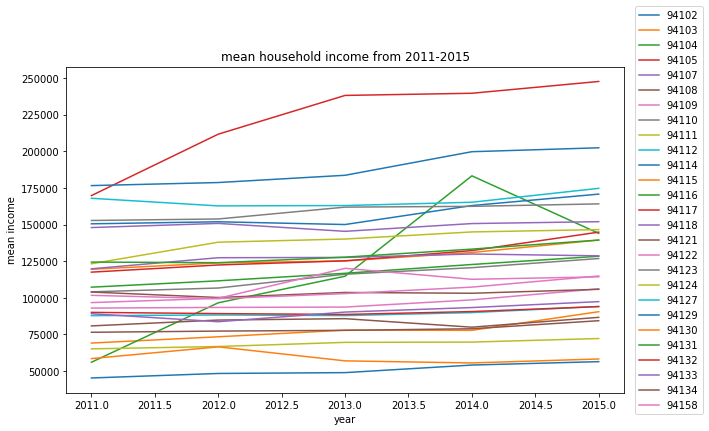

In [407]:
#df_income.set_index('GEO.id2',inplace=True)

x = [2011,2012,2013,2014,2015]
y = df_income.iloc[:,1:6].copy().T

fig, ax = plt.subplots(1,1,figsize = (10,6))
plt.plot(x,y)
plt.legend(df_income['GEO.id2'], loc=9, bbox_to_anchor=(1.08, 1.2))
plt.xlabel('year')
plt.ylabel('mean income')
plt.title('mean household income from 2011-2015')

In [408]:
# increase rate at 2015 cf to 2011
df_income['increase_rate'] = (df_income['mean_15']-df_income['mean_11'])*100.0/df_income['mean_11']
df_income = df_income.sort_values(by=['increase_rate'],ascending=False)
df_income.mean()

GEO.id2          3.485368e+133
mean_11           1.071962e+05
mean_12           1.122313e+05
mean_13           1.162496e+05
mean_14           1.218218e+05
mean_15           1.253307e+05
increase_rate     1.912894e+01
dtype: float64

In [409]:
# use the median increase rate as a criteria to judge whether a zipcode has been gentrified or not
rate_criteria = df_income.increase_rate.median()

> Regions where income has increased by more than 40% 

In [410]:
df_gen = df_income[df_income['increase_rate']>1.4*rate_criteria]
df_gen['GEO.id2'].astype(int)

2     94104
3     94105
1     94103
0     94102
13    94117
7     94110
12    94116
8     94111
26    94158
Name: GEO.id2, dtype: int64

In [411]:
df_gen

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate
2,94104,55996,96572,114709,183221,143978,157.121937
3,94105,169743,211655,238101,239576,247624,45.881715
1,94103,69089,73372,77913,77778,90489,30.974540
0,94102,45260,48334,48910,54084,56397,24.606717
13,94117,117486,122381,125203,132201,144804,23.252132
7,94110,104044,106657,116075,120535,126780,21.852293
12,94116,107232,111568,116706,122711,128327,19.672299
8,94111,123222,137929,140092,144931,146520,18.907338
26,94158,96700,99614,120081,112612,114277,18.176836


In [412]:
df_gen = df_gen.drop([26]) # not found in zipcode database

In [413]:
df_gen.dtypes

GEO.id2           object
mean_11            int64
mean_12            int64
mean_13            int64
mean_14            int64
mean_15            int64
increase_rate    float64
dtype: object

In [414]:
# find coordinates for zipcodes
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()
df_gen['lon'] = df_gen.apply(lambda x: zcdb[x['GEO.id2']].longitude, axis = 1)
df_gen['lat'] = df_gen.apply(lambda x: zcdb[x['GEO.id2']].latitude, axis = 1)
df_gen

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate,lon,lat
2,94104,55996,96572,114709,183221,143978,157.121937,-122.40190,37.791728
3,94105,169743,211655,238101,239576,247624,45.881715,-122.39570,37.789228
1,94103,69089,73372,77913,77778,90489,30.974540,-122.41087,37.772329
0,94102,45260,48334,48910,54084,56397,24.606717,-122.41915,37.779329
13,94117,117486,122381,125203,132201,144804,23.252132,-122.44276,37.770937
7,94110,104044,106657,116075,120535,126780,21.852293,-122.41545,37.748730
12,94116,107232,111568,116706,122711,128327,19.672299,-122.48578,37.743381
8,94111,123222,137929,140092,144931,146520,18.907338,-122.40027,37.798228


> calculate income increase rate etc

In [415]:
df_pop_diff = pd.merge(df_pop_11_SF[['GEO.id2','total_household_11']], 
                    df_pop_15_SF[['GEO.id2','total_household_15']], 
                    on='GEO.id2')

df_pop_diff['total_diff'] = df_pop_diff['total_household_15'].astype(int)-df_pop_diff['total_household_11'].astype(int)

In [416]:
# income mean for each year
df_income.describe()

,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,107196.185185,112231.333333,116249.555556,121821.814815,125330.740741,19.128938
std,36179.853517,38047.387511,41065.325905,44679.320978,43583.071468,29.304217
min,45260.000000,48334.000000,48910.000000,54084.000000,56397.000000,-0.453038
25%,84301.000000,86519.500000,88228.500000,90236.000000,94015.000000,7.314236
50%,103909.000000,100179.000000,116075.000000,120535.000000,126780.000000,12.973473
75%,123789.500000,132630.500000,133901.000000,147787.000000,145662.000000,19.289819
max,176556.000000,211655.000000,238101.000000,239576.000000,247624.000000,157.121937


In [417]:
# find population income lower than 40% of the mean income 
np.array([107196.185185, 112231.333333, 116249.555556,121821.814815,125330.740741])*0.4
# they all fall in category between HC01_EST_VC_02 and  HC01_EST_VC_02 

array([ 42878.474074 ,  44892.5333332,  46499.8222224,  48728.725926 ,
        50132.2962964])

In [418]:
# get low income population in 2011 and 2015
df_pop_diff = pd.merge(df_pop_diff, 
                    df_pop_11_SF[['GEO.id2','HC01_EST_VC02','HC01_EST_VC03','HC01_EST_VC04','HC01_EST_VC05','HC01_EST_VC06']], 
                    on='GEO.id2')

df_pop_diff.head()


,GEO.id2,total_household_11,total_household_15,total_diff,HC01_EST_VC02,HC01_EST_VC03,HC01_EST_VC04,HC01_EST_VC05,HC01_EST_VC06
0,94102,14884,16463,1579,18.6,17.2,17.5,9.1,10.3
1,94103,11230,12728,1498,11.7,13.9,11.5,7.1,11.0
2,94104,189,176,-13,9.0,24.3,10.1,29.1,0.0
3,94105,2769,3778,1009,3.6,2.7,1.6,4.9,8.0
4,94107,13028,13743,715,5.1,3.1,6.8,4.5,5.1


In [419]:
df_pop_diff['low_11'] = ((df_pop_diff['HC01_EST_VC02'].astype(float)+df_pop_diff['HC01_EST_VC03'].astype(float)\
                        +df_pop_diff['HC01_EST_VC04'].astype(float)+df_pop_diff['HC01_EST_VC05'].astype(float)\
                        +df_pop_diff['HC01_EST_VC06'].astype(float)))/100
columns = ['HC01_EST_VC02', 'HC01_EST_VC03','HC01_EST_VC04','HC01_EST_VC05','HC01_EST_VC06']
df_pop_diff.drop(columns, inplace=True, axis=1)
df_pop_diff.head()

,GEO.id2,total_household_11,total_household_15,total_diff,low_11
0,94102,14884,16463,1579,0.727
1,94103,11230,12728,1498,0.552
2,94104,189,176,-13,0.725
3,94105,2769,3778,1009,0.208
4,94107,13028,13743,715,0.246


In [420]:
# get low income population 2015
df_pop_diff = pd.merge(df_pop_diff, 
                    df_pop_15_SF[['GEO.id2','HC01_EST_VC02','HC01_EST_VC03','HC01_EST_VC04','HC01_EST_VC05','HC01_EST_VC06']], 
                    on='GEO.id2')


df_pop_diff['low_15'] = ((df_pop_diff['HC01_EST_VC02'].astype(float)+df_pop_diff['HC01_EST_VC03'].astype(float)\
                        +df_pop_diff['HC01_EST_VC04'].astype(float)+df_pop_diff['HC01_EST_VC05'].astype(float)\
                        +df_pop_diff['HC01_EST_VC06'].astype(float)))/100
columns = ['HC01_EST_VC02', 'HC01_EST_VC03','HC01_EST_VC04','HC01_EST_VC05','HC01_EST_VC06']
df_pop_diff.drop(columns, inplace=True, axis=1)

In [421]:
df_pop_diff.head()

,GEO.id2,total_household_11,total_household_15,total_diff,low_11,low_15
0,94102,14884,16463,1579,0.727,0.667
1,94103,11230,12728,1498,0.552,0.538
2,94104,189,176,-13,0.725,0.529
3,94105,2769,3778,1009,0.208,0.107
4,94107,13028,13743,715,0.246,0.245


In [422]:
df_pop_diff['population_increase'] = (df_pop_diff['total_household_15'].astype(int)-df_pop_diff['total_household_11'].astype(int))*1.0/df_pop_diff['total_household_11'].astype(float)

In [423]:
df_pop_diff['low_increase_rate'] = (df_pop_diff['low_15']-df_pop_diff['low_11'])/df_pop_diff['low_11']
df_pop_diff.head()

,GEO.id2,total_household_11,total_household_15,total_diff,low_11,low_15,population_increase,low_increase_rate
0,94102,14884,16463,1579,0.727,0.667,0.106087,-0.082531
1,94103,11230,12728,1498,0.552,0.538,0.133393,-0.025362
2,94104,189,176,-13,0.725,0.529,-0.068783,-0.270345
3,94105,2769,3778,1009,0.208,0.107,0.364391,-0.485577
4,94107,13028,13743,715,0.246,0.245,0.054882,-0.004065


1. overall population <font color=red> ↑ </font> : low-income households <font color=red> ↓ more than 40%</font>
2. overall population <font color=red> ↓ </font> : the rate of low-income households <font color=red> ↓ </font> at a 40% or more faster rate than the overall population decline

In [424]:
df_pop_gen = df_pop_diff[((df_pop_diff['population_increase'] > 0) & \
             (df_pop_diff['low_increase_rate'] < -0.4))\
            | ((df_pop_diff['population_increase'] < 0) \
               & (abs(df_pop_diff['low_increase_rate']) > 1.4*abs(df_pop_diff['population_increase'])))]

> zipcodes of regions that has been gentrified according to mentioned criteria

In [425]:
df_pop_gen['GEO.id2']

2     94104
3     94105
8     94111
10    94114
13    94117
15    94121
19    94127
22    94131
23    94132
24    94133
Name: GEO.id2, dtype: object

> find coordinates for gentrified zip code areas
> Geocoding

In [426]:
df_pop_gen.head()

,GEO.id2,total_household_11,total_household_15,total_diff,low_11,low_15,population_increase,low_increase_rate
2,94104,189,176,-13,0.725,0.529,-0.068783,-0.270345
3,94105,2769,3778,1009,0.208,0.107,0.364391,-0.485577
8,94111,2227,2118,-109,0.337,0.362,-0.048945,0.074184
10,94114,16733,16456,-277,0.223,0.185,-0.016554,-0.170404
13,94117,18468,18362,-106,0.278,0.232,-0.005740,-0.165468


In [427]:
from pygeocoder import Geocoder
results = Geocoder.reverse_geocode(37.70808923327349, -122.51494757834968,)

In [428]:
results.postal_code

u'94132'

In [429]:
df_pop_gen.dtypes

GEO.id2                 object
total_household_11      object
total_household_15      object
total_diff               int64
low_11                 float64
low_15                 float64
population_increase    float64
low_increase_rate      float64
dtype: object

In [430]:
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()
df_pop_gen['lon'] = df_pop_gen.apply(lambda x: zcdb[x['GEO.id2']].longitude, axis = 1)
df_pop_gen['lat'] = df_pop_gen.apply(lambda x: zcdb[x['GEO.id2']].latitude, axis = 1)
     
df_pop_gen

,GEO.id2,total_household_11,total_household_15,total_diff,low_11,low_15,population_increase,low_increase_rate,lon,lat
2,94104,189,176,-13,0.725,0.529,-0.068783,-0.270345,-122.40190,37.791728
3,94105,2769,3778,1009,0.208,0.107,0.364391,-0.485577,-122.39570,37.789228
8,94111,2227,2118,-109,0.337,0.362,-0.048945,0.074184,-122.40027,37.798228
10,94114,16733,16456,-277,0.223,0.185,-0.016554,-0.170404,-122.43512,37.758434
13,94117,18468,18362,-106,0.278,0.232,-0.005740,-0.165468,-122.44276,37.770937
15,94121,17463,17388,-75,0.347,0.365,-0.004295,0.051873,-122.49265,37.778729
19,94127,7258,7208,-50,0.163,0.192,-0.006889,0.177914,-122.45970,37.734964
22,94131,13262,13254,-8,0.249,0.231,-0.000603,-0.072289,-122.43780,37.741797
23,94132,10551,10391,-160,0.358,0.376,-0.015164,0.050279,-122.47958,37.724231
24,94133,13444,13230,-214,0.498,0.475,-0.015918,-0.046185,-122.41018,37.801878


> a sneak peek at where are those zip zode regions

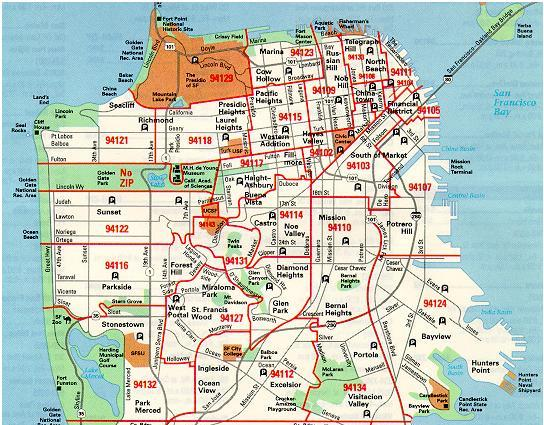

In [431]:
from IPython.display import Image
PATH = "/Users/fangjie/Desktop/"
Image(filename = PATH + "SF_Zip-Code_Map.jpg", width=600, height=600)

> - mission 
> - soma
> - financial district
> - north beach

> ### sentiment analysis 

<h2 style="text-align: center;" markdown="1">Housing price</h2>

> ## housing data
> Files (in .CSV format) downloaded from Zillow Research https://www.zillow.com/research/data/#bulk
> Organized in different geographies
- Obtain San Francisco data from all other cities
- What is the temporal change of house prices in gentrified regions compared to the rest?

In [432]:
# House value data, Data source: Zillow https://www.zillow.com/research/data/#bulk
df_price = pd.read_csv('/Users/fangjie/Workspace/mockinterviews/Data_Incubator/data/Neighborhood/Neighborhood_Zhvi_AllHomes.csv')

In [433]:
df_price.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09
0,274772,Northeast Dallas,Dallas,TX,Dallas-Fort Worth,Dallas,1,NaN,NaN,NaN,...,277500,278300,281600,285900,289900,292900,292900,291800,290900,290100
1,192689,Paradise,Las Vegas,NV,Las Vegas,Clark,2,115400.0,115300.0,115500.0,...,196500,199100,201400,202900,204200,206300,208900,211100,213400,215500
2,112345,Maryvale,Phoenix,AZ,Phoenix,Maricopa,3,58900.0,58900.0,58900.0,...,147500,148300,148600,148900,149500,150800,152500,153900,155100,156100
3,27080,Sherman Oaks,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,4,216200.0,218200.0,218900.0,...,869700,872500,876200,879500,882400,886400,891100,896200,903200,910200
4,118208,South Los Angeles,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,5,117600.0,118700.0,119600.0,...,401900,406100,411000,417300,423400,427100,429700,432500,435300,437500


In [434]:
df_price.dtypes

RegionID        int64
RegionName     object
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
1996-04       float64
1996-05       float64
1996-06       float64
1996-07       float64
1996-08       float64
1996-09       float64
1996-10       float64
1996-11       float64
1996-12       float64
1997-01       float64
1997-02       float64
1997-03       float64
1997-04       float64
1997-05       float64
1997-06       float64
1997-07       float64
1997-08       float64
1997-09       float64
1997-10       float64
1997-11       float64
1997-12       float64
1998-01       float64
1998-02       float64
               ...   
2015-04         int64
2015-05         int64
2015-06         int64
2015-07         int64
2015-08         int64
2015-09         int64
2015-10         int64
2015-11         int64
2015-12         int64
2016-01         int64
2016-02       float64
2016-03       float64
2016-04       float64
2016-05       float64
2016-06   

> quick look at housing price vs time 

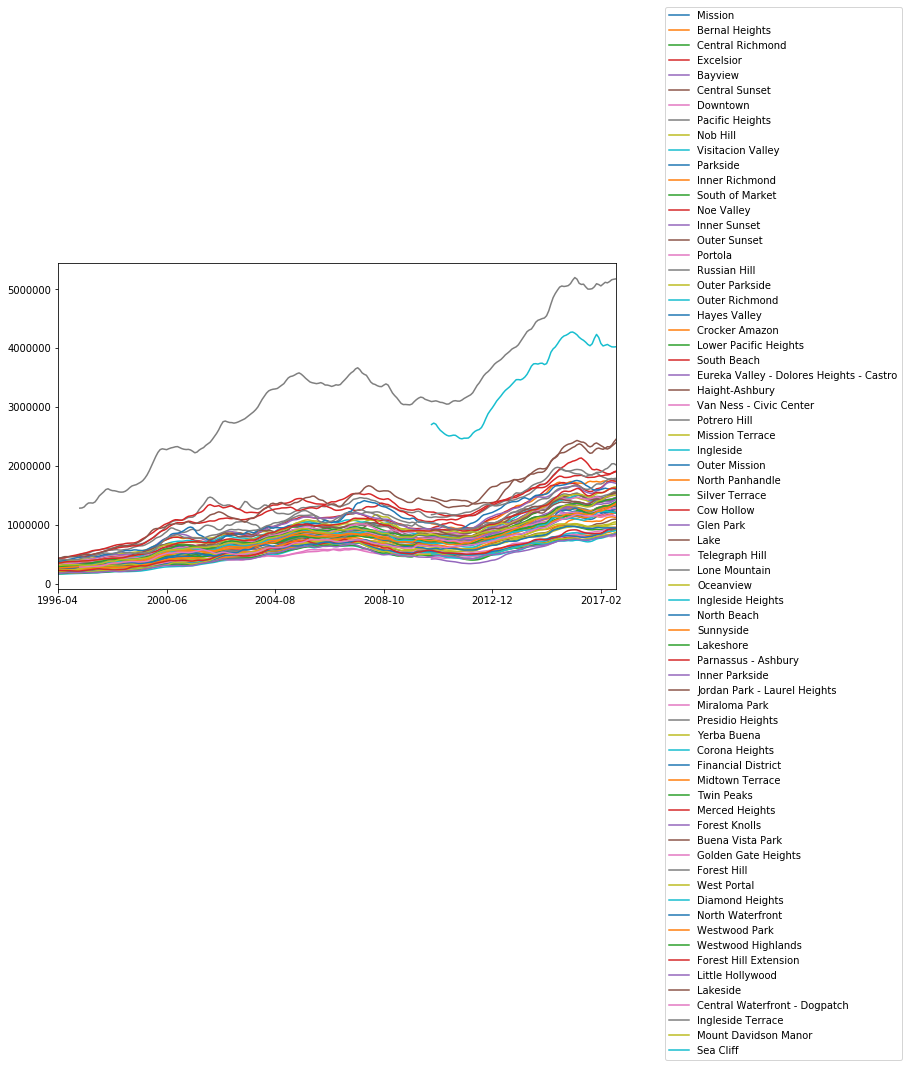

In [435]:
fig, ax = plt.subplots(1,1,figsize = (10,6))
d = df_price[df_price.City == 'San Francisco']
d.set_index(d.RegionName, inplace = True)
t = d[lambda df: df.columns[7:]].transpose()
t.plot(ax = ax)
plt.legend(loc=9, bbox_to_anchor=(1.3, 1.8))

# quick look at what the data looks like

In [436]:
# # of missing values, top 7 regions have same number of missing values
pd.Series(t.isnull().sum()).sort_values(ascending=False).head(10)

RegionName
Sea Cliff            172
Bayview              172
Lakeside             172
Inner Richmond       172
Forest Hill          172
Lake                 172
Ingleside Heights    172
Ingleside             16
Presidio Heights      10
Bernal Heights        10
dtype: int64

> Fliter out 2011 -2015 year data, so that we can compare with other data

In [437]:
df_price = df_price[df_price.City == 'San Francisco']
df_price['avg_price_2011'] = df_price[[col for col in list(df_price) if col.startswith('2011')]].mean(axis = 1, skipna=None)
df_price['avg_price_2015'] = df_price[[col for col in list(df_price) if col.startswith('2015')]].mean(axis = 1, skipna=None)
df_price['avg_price_increase_2011_to_2015'] = 100.0*(df_price['avg_price_2015'] / df_price['avg_price_2011'] - 1)
df_price.set_index(df_price.RegionID, inplace = True)
df_price.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,avg_price_2011,avg_price_2015,avg_price_increase_2011_to_2015
RegionID,,,,,,,,,,,,,,,,,,,,,
274552,274552,Mission,San Francisco,CA,San Francisco,San Francisco,99,226900.0,226100.0,224400.0,...,1292100,1299500,1299800,1301200,1313700,1336700,1357700,702566.666667,1.200008e+06,70.803482
268020,268020,Bernal Heights,San Francisco,CA,San Francisco,San Francisco,314,NaN,NaN,NaN,...,1323600,1333200,1331400,1335500,1346800,1351800,1350600,693591.666667,1.152433e+06,66.154438
117654,117654,Central Richmond,San Francisco,CA,San Francisco,San Francisco,380,327600.0,332100.0,337800.0,...,1421300,1425400,1424900,1419200,1422500,1441900,1462000,784341.666667,1.384692e+06,76.541898
268150,268150,Excelsior,San Francisco,CA,San Francisco,San Francisco,390,190900.0,191300.0,191800.0,...,851500,866900,882300,896300,905900,914400,921900,497141.666667,7.659417e+05,54.069095
272885,272885,Bayview,San Francisco,CA,San Francisco,San Francisco,449,NaN,NaN,NaN,...,795200,808700,820000,826800,828300,834000,843400,374316.666667,7.181667e+05,91.860724


> Quick test: Known Gentrified District (news), mission district 

In [438]:
# the mission district which has been reported to have been gentrified
list_of_gentrification_areas = ['Mission']

# list_of_gentrification_areas = ['Mission','South of Market', 'Van Ness - Civic Center', 'China Town']
# list_of_rich_area = ['']

> House price increase rate significantly higher than other regions?

Text(0,0.5,u'Median Housing Price Increase since 2011')

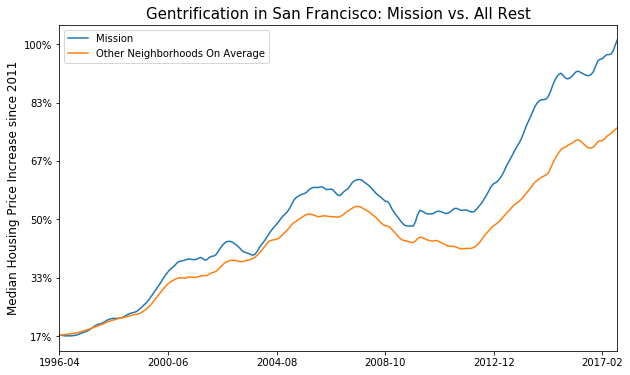

In [480]:
fig, ax = plt.subplots(1,1,figsize = (10,6))
j = 0
t['rescaled_price_accumulate'] = 0
for i, n in enumerate(t.columns):
    t['rescaled_price'] = t[n]/t[n].min()
    
    # directly plot out gentrification areas:
    if n in list_of_gentrification_areas:
        t.rescaled_price.plot(ax = ax, label = n)
    
    # remember non-gentrification areas:
    elif not t.rescaled_price.isnull().values.any():
        t['rescaled_price_accumulate'] += t['rescaled_price']
        j += 1

# at end, plot areas except for gentrification areas on overage..
(t['rescaled_price_accumulate']/j).plot(ax = ax, label = 'Other Neighborhoods On Average')

ax.legend()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/6))) 
# need to double check
plt.title("Gentrification in San Francisco: Mission vs. All Rest", fontsize = 15)
ax.set_ylabel("Median Housing Price Increase since 2011", fontsize = 12)

> ## crime data
> San Francisco police department data queried from API https://data.sfgov.org

> Sign of gentrification
- significant decrease of crime rate often used as an indicator for gentrification

In [440]:
# for now, use 10,000 data points

# sf police data https://data.sfgov.org/resource/PdId.json
# registered business data: vbiu-2p9h for future analysis 
from sodapy import Socrata

client = Socrata("data.sfgov.org", None)

#client = Socrata("data.sfgov.org",
#               ,
#                "fangjieliu.duke@gmail.com",
#                "password")
# https://data.sfgov.org/resource/gxxq-x39z.json

# dictionaries by sodapy. cuks-n6tp
business = client.get("vbiu-2p9h",limit=100000)
incidents = client.get("gxxq-x39z",limit=50000)
# Convert to pandas DataFrame
df_business = pd.DataFrame.from_records(business)
df_incidents = pd.DataFrame.from_records(incidents)

In [441]:
mask = (df_incidents['date'] < '2015-12-31') & (df_incidents['date'] > '2011-01-01')
df_incidents['date'] = pd.to_datetime(df_incidents['date'])
df_incidents['year'] = df_incidents['date'].dt.year

In [442]:
df_incidents.dtypes

address               object
category              object
date          datetime64[ns]
dayofweek             object
descript              object
incidntnum            object
location              object
pddistrict            object
resolution            object
time                  object
x                     object
y                     object
year                   int64
dtype: object

In [443]:
df_incidents = df_incidents[mask]

In [444]:
df_i = df_incidents[['incidntnum','x','y','pddistrict','year','category']]

In [445]:
df_i['x'] = df_i['x'].astype(float)
df_i['y'] = df_i['y'].astype(float)

In [446]:
df_i.head()

,incidntnum,x,y,pddistrict,year,category
2,130366639,-122.444707,37.724931,INGLESIDE,2013,ASSAULT
4,130839567,-122.414056,37.782793,TENDERLOIN,2013,OTHER OFFENSES
9,110051822,-122.408761,37.715900,INGLESIDE,2011,NON-CRIMINAL
11,110929398,-122.416015,37.755546,MISSION,2011,LARCENY/THEFT
12,140196921,-122.437928,37.719328,INGLESIDE,2014,"SEX OFFENSES, FORCIBLE"


> find corresponding zipcode zones from coordinates

In [447]:
#from googlemaps import GoogleMaps
#gmaps = GoogleMaps(api_key)
#reverse = gmaps.reverse_geocode(38.887563, -77.019929)

In [448]:
df_is = df_i.groupby(['pddistrict','year'], as_index=False)['incidntnum'].count()

In [449]:
df_is = df_is.sort_values(by=['pddistrict'])

In [450]:
df_is.head()

,pddistrict,year,incidntnum
0,BAYVIEW,2011,397
1,BAYVIEW,2012,425
2,BAYVIEW,2013,489
3,BAYVIEW,2014,402
4,BAYVIEW,2015,35


In [451]:

df_i_rate = pd.DataFrame([])
df_i_15 = df_is[df_is['year'] == 2015][['pddistrict','incidntnum']]
df_i_11 = df_is[df_is['year'] == 2011][['pddistrict','incidntnum']]

df_i_11.set_index('pddistrict', inplace=True)
df_i_15.set_index('pddistrict', inplace=True)

df_i_rate['district'] = df_is[df_is['year']==2015].pddistrict
df_i_rate.set_index('district', inplace=True)
df_i_rate['crime_rate'] = (df_i_15['incidntnum'].astype(float)\
                            /df_i_15['incidntnum'].astype(int).sum()\
                         -df_i_11['incidntnum'].astype(float)\
                        /df_i_11['incidntnum'].astype(int).sum())

In [452]:
df_i_rate

,crime_rate
district,
BAYVIEW,-0.007856
CENTRAL,-0.003561
INGLESIDE,0.005415
MISSION,-0.028710
NORTHERN,0.023655
PARK,0.008588
RICHMOND,-0.005545
SOUTHERN,-0.011781
TARAVAL,0.025290


In [453]:
df_i1 = df_i.groupby(['pddistrict','year'], as_index=False)[['x','y']].agg(['mean', 'count'])

In [454]:
#df1 = df.groupby(['pddistrict','year'], as_index=False)[['x','y']].agg(['mean', 'count'])
df_i1.head(20)

x                y      
                       mean count       mean count
pddistrict year                                   
BAYVIEW    2011 -122.393556   397  37.735935   397
           2012 -122.394011   425  37.737754   425
           2013 -122.393429   489  37.738282   489
           2014 -122.392648   402  37.736982   402
           2015 -122.394785    35  37.739559    35
CENTRAL    2011 -122.409164   370  37.795712   370
           2012 -122.409202   423  37.795212   423
           2013 -122.409110   424  37.795482   424
           2014 -122.409113   492  37.795941   492
           2015 -122.410051    34  37.797546    34
INGLESIDE  2011 -122.428986   325  37.727346   325
           2012 -122.428667   352  37.726153   352
           2013 -122.429286   388  37.726754   388
           2014 -122.428860   408  37.726719   408
           2015 -122.427960    33  37.728309    33
MISSION    2011 -122.419783   582  37.759847   582
           2012 -122.419176   544  37.759974   544
           2013 -122.420062   602  37.760392   602
           2014 -122.419535   550  37.760256   550
           2015 -122.419942    45  37.758883    45

In [455]:
df_i1.index.get_level_values('pddistrict')

Index([u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'CENTRAL',
       u'CENTRAL', u'CENTRAL', u'CENTRAL', u'CENTRAL', u'INGLESIDE',
       u'INGLESIDE', u'INGLESIDE', u'INGLESIDE', u'INGLESIDE', u'MISSION',
       u'MISSION', u'MISSION', u'MISSION', u'MISSION', u'NORTHERN',
       u'NORTHERN', u'NORTHERN', u'NORTHERN', u'NORTHERN', u'PARK', u'PARK',
       u'PARK', u'PARK', u'PARK', u'RICHMOND', u'RICHMOND', u'RICHMOND',
       u'RICHMOND', u'RICHMOND', u'SOUTHERN', u'SOUTHERN', u'SOUTHERN',
       u'SOUTHERN', u'SOUTHERN', u'TARAVAL', u'TARAVAL', u'TARAVAL',
       u'TARAVAL', u'TARAVAL', u'TENDERLOIN', u'TENDERLOIN', u'TENDERLOIN',
       u'TENDERLOIN', u'TENDERLOIN'],
      dtype='object', name=u'pddistrict')

In [456]:
df_i1.head()

x                y      
                       mean count       mean count
pddistrict year                                   
BAYVIEW    2011 -122.393556   397  37.735935   397
           2012 -122.394011   425  37.737754   425
           2013 -122.393429   489  37.738282   489
           2014 -122.392648   402  37.736982   402
           2015 -122.394785    35  37.739559    35

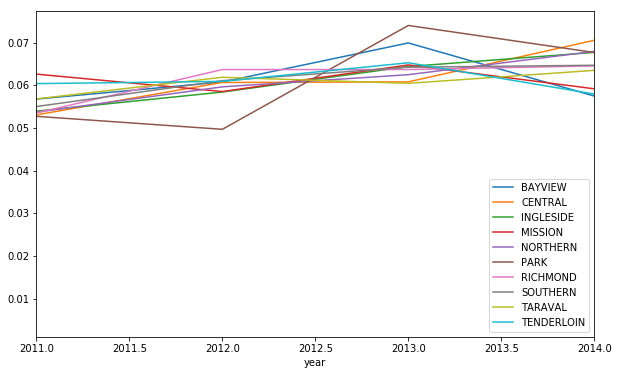

In [457]:
rate_crime=pd.DataFrame({})
fig, ax = plt.subplots(1,1,figsize = (10,6))
for d in df_i1.index.get_level_values('pddistrict').unique():
    df_tmp = df_i1.loc[d]
    rate_crime[d] = 1.0*df_tmp.x['count']/df_tmp.x['count'].sum()/4
    (rate_crime[d]).plot(ax = ax, label = d)
plt.xlim((2011,2014))
plt.legend(loc = 'lower right')

> let's check the crime rate change

In [458]:
df_i1.index.get_level_values('pddistrict')

Index([u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'BAYVIEW', u'CENTRAL',
       u'CENTRAL', u'CENTRAL', u'CENTRAL', u'CENTRAL', u'INGLESIDE',
       u'INGLESIDE', u'INGLESIDE', u'INGLESIDE', u'INGLESIDE', u'MISSION',
       u'MISSION', u'MISSION', u'MISSION', u'MISSION', u'NORTHERN',
       u'NORTHERN', u'NORTHERN', u'NORTHERN', u'NORTHERN', u'PARK', u'PARK',
       u'PARK', u'PARK', u'PARK', u'RICHMOND', u'RICHMOND', u'RICHMOND',
       u'RICHMOND', u'RICHMOND', u'SOUTHERN', u'SOUTHERN', u'SOUTHERN',
       u'SOUTHERN', u'SOUTHERN', u'TARAVAL', u'TARAVAL', u'TARAVAL',
       u'TARAVAL', u'TARAVAL', u'TENDERLOIN', u'TENDERLOIN', u'TENDERLOIN',
       u'TENDERLOIN', u'TENDERLOIN'],
      dtype='object', name=u'pddistrict')

In [459]:
df_i_rate.sort_values(by='crime_rate',ascending = False)

,crime_rate
district,
TARAVAL,0.025290
NORTHERN,0.023655
PARK,0.008588
INGLESIDE,0.005415
CENTRAL,-0.003561
TENDERLOIN,-0.005495
RICHMOND,-0.005545
BAYVIEW,-0.007856
SOUTHERN,-0.011781


> ### Crime rate did decrease most dramatically in Mission

<h2 style="text-align: center;" markdown="1">Overlay crime and housing data</h2>

## prepare data

In [460]:
# load shapefile
# download boundary files of states here: https://www.zillow.com/howto/api/neighborhood-boundaries.htm
shapefilename = '/Users/fangjie/Workspace/mockinterviews/Data_Incubator/data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA'
# shapefilename = '/Users/fangjie/Downloads/Zoning Districts/geo_export_ff16c4b8-5bf2-4e47-a498-6513bb52d237'
shp = fiona.open(shapefilename+'.shp')
coords = shp.bounds
coords = (-122.51494757834968,
 37.70808923327349,
 -122.35696687665978,
 37.81157429336938)

shp.close()
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01
coords

(-122.51494757834968,
 37.70808923327349,
 -122.35696687665978,
 37.81157429336938)

In [461]:
df_gen 

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate,lon,lat
2,94104,55996,96572,114709,183221,143978,157.121937,-122.40190,37.791728
3,94105,169743,211655,238101,239576,247624,45.881715,-122.39570,37.789228
1,94103,69089,73372,77913,77778,90489,30.974540,-122.41087,37.772329
0,94102,45260,48334,48910,54084,56397,24.606717,-122.41915,37.779329
13,94117,117486,122381,125203,132201,144804,23.252132,-122.44276,37.770937
7,94110,104044,106657,116075,120535,126780,21.852293,-122.41545,37.748730
12,94116,107232,111568,116706,122711,128327,19.672299,-122.48578,37.743381
8,94111,123222,137929,140092,144931,146520,18.907338,-122.40027,37.798228


## Visualize with basemap

In [462]:
# create basemap object
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

_out = m.readshapefile(shapefilename, name='SF', drawbounds=False, color='none', zorder=2)


In [463]:
# prepare data
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(hood_points) for hood_points in m.SF],
    'name': [hood['Name'] for hood in m.SF_info],
    'city': [hood['City'] for hood in m.SF_info],
    'RegionID': [hood['RegionID'] for hood in m.SF_info],
})

# drop some duplicates
df_map = df_map.drop_duplicates(subset = ['RegionID'])
df_map = df_map[df_map.city == 'San Francisco']
df_map['RegionID'] = df_map.RegionID.astype('int')
df_map.set_index(df_map.RegionID, inplace=True)

In [464]:
# join data together
df_map = df_map.join(df_price, how='inner', on = 'RegionID', lsuffix='_map', rsuffix='_price')

In [465]:
#df_map2 = pd.DataFrame({
#    'poly': [Polygon(hood_points) for hood_points in m.SF],
#    'name': [hood['Name'] for hood in m.SF_info],
#    'city': [hood['City'] for hood in m.SF_info],
#    'RegionID': [hood['RegionID'] for hood in m.SF_info],
#    })
#df_map2 = df_map2[df_map2.city == 'San Francisco']
#df_map2['poly_patch']=df_map2['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))

#def in_which_region(lat, lon):
#    try:
#        p = Point(m(lon, lat))
#        for index, row in df_map2.iterrows():
#            if row['poly'].contains(p):
#                return row['name']
#                #break
#            #print row['name']
#    except:
#        return None

In [466]:
# df_incidents['hood_name'] = df_incidents.apply(lambda z: in_which_region(float(z.y), float(z.x)), axis = 1)

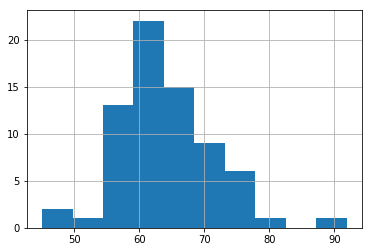

In [467]:
df_map.avg_price_increase_2011_to_2015.hist()

In [468]:
# visualize
breaks = [50.] + [ 60, 70, 80, 90.] + [100]

def self_categorize(entry, breaks):
    for i in range(len(breaks)-1):
        if entry > breaks[i] and entry <= breaks[i+1]:
            return i
    return -1
df_map['jenks_bins'] = df_map.avg_price_increase_2011_to_2015.apply(self_categorize, args=(breaks,))

jenks_labels = ['0-50%% Increase']+[">%d%% Increase"%(perc) for perc in breaks[:-1]]

# from pysal.esda.mapclassify import Natural_Breaks
# breaks = Natural_Breaks(df_map.avg_price_increase_2005_to_2017, initial=0, k=5)
# df_map['jenks_bins'] = -1 #default value if no data exists for this bin
# df_map['jenks_bins'][df_map.avg_price_increase_2005_to_2017 > 0] = breaks.yb
# jenks_labels = ['', "baseline"]+["> %d increase"%(perc) for perc in breaks.bins[:-1]]


In [469]:
def custom_colorbar(cmap, ncolors, labels, **kwargs):    
    """Create a custom, discretized colorbar with correctly formatted/aligned labels.
    cmap: the matplotlib colormap object you plan on using for your graph
    ncolors: (int) the number of discrete colors available
    labels: the list of labels for the colorbar. Should be the same length as ncolors.
    """
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
        
    norm = BoundaryNorm(range(0, ncolors), cmap.N)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors+1)+0.5)
    colorbar.set_ticklabels(range(0, ncolors))
    colorbar.set_ticklabels(labels)
    return colorbar

In [470]:
df_gen

,GEO.id2,mean_11,mean_12,mean_13,mean_14,mean_15,increase_rate,lon,lat
2,94104,55996,96572,114709,183221,143978,157.121937,-122.40190,37.791728
3,94105,169743,211655,238101,239576,247624,45.881715,-122.39570,37.789228
1,94103,69089,73372,77913,77778,90489,30.974540,-122.41087,37.772329
0,94102,45260,48334,48910,54084,56397,24.606717,-122.41915,37.779329
13,94117,117486,122381,125203,132201,144804,23.252132,-122.44276,37.770937
7,94110,104044,106657,116075,120535,126780,21.852293,-122.41545,37.748730
12,94116,107232,111568,116706,122711,128327,19.672299,-122.48578,37.743381
8,94111,123222,137929,140092,144931,146520,18.907338,-122.40027,37.798228


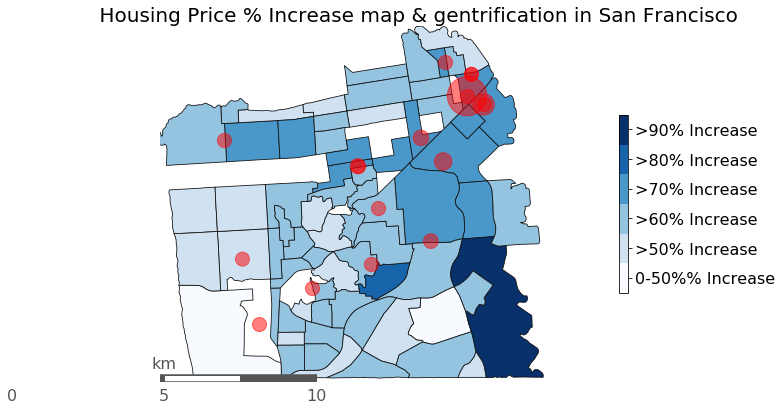

In [484]:
figwidth = 10
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)


cmap = plt.get_cmap('Blues')

# draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)

# apply our custom color values onto the patch collection
cmap_list = [cmap(val) for val in (df_map.jenks_bins.values - df_map.jenks_bins.values.min())/(
                  df_map.jenks_bins.values.max()-float(df_map.jenks_bins.values.min()))]
pc.set_facecolor(cmap_list)
ax.add_collection(pc)



#Draw a map scale
m.drawmapscale(coords[0], coords[1],
    coords[0], coords[1], 10.,
    fontsize=16, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5, ax=ax,)

# ncolors+1 because we're using a "zero-th" color
cbar = custom_colorbar(cmap, ncolors=len(jenks_labels)+1, labels=jenks_labels, shrink=0.5)
cbar.ax.tick_params(labelsize=16)


### overlay incidents data on top of map

import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.hot
norm = Normalize(vmin=2011, vmax=2015)

#for iyear in range(2011,2015,1):
#    aa = df_i1.loc[(df_i1.index.get_level_values('year') == iyear)]
#    #cats = aa.index.get_level_values('category').values
#    #tempmark = [mapping[cat] for cat in cats]
#    lons = aa.x['mean'].values
#    lats = aa.y['mean'].values
#    incounts= aa.x['count'].values
#    x,y = m(lons, lats)
   # plt.scatter(x, y, s=incounts, c=cmap(norm(iyear)),marker=tempmark, alpha=0.3)
#    plt.scatter(x, y, s=incounts, c=cmap(norm(iyear)),marker ='>',alpha=0.3)

### mark regions with high income increase rates from 2011-2015
xx, yy = m(np.array(df_pop_gen['lon']), np.array(df_pop_gen['lat']))
plt.scatter(xx,yy,s=200, c='r',alpha=0.5)

xx, yy = m(np.array(df_gen['lon']), np.array(df_gen['lat']))
plt.scatter(xx,yy,s=df_gen.increase_rate*10, c='r',alpha=0.5)

fig.suptitle(" Housing Price % Increase map & gentrification in San Francisco", fontsize = 5, fontdict={'size':20, 'fontweight':'bold'}, y=0.92)
#ax.set_title("Using location data collected from my Android phone via Google Takeout", fontsize=14, y=0.98)
# qax.text(1.35, 0.04, "Collected from 2012-2014 on Android 4.2-4.4\nGeographic data provided by data.seattle.gov", 
#     ha='right', color='#555555', style='italic', transform=ax.transAxes)
# ax.text(1.35, 0.01, "BeneathData.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)

plt.savefig('San Francisco 2011-2015 housing price changes.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

In [472]:
df_i_rate.sort_values(by='crime_rate')

,crime_rate
district,
MISSION,-0.028710
SOUTHERN,-0.011781
BAYVIEW,-0.007856
RICHMOND,-0.005545
TENDERLOIN,-0.005495
CENTRAL,-0.003561
INGLESIDE,0.005415
PARK,0.008588
NORTHERN,0.023655


>+ #### Found gentrified regions via quantitative definition with population and income data 
+ #### Gentrified regions has relatively significant decrease in crime rate 
+ #### Gentrified regions has higher housing price increase


<h1 style="text-align: center;" markdown="1"><font color=black>What to do </font> </h1>

+ ### A machine learning model that captures current gentrification trend and predicts future. 
    More comprehensive signals:
    - ** housing **: % change house values, % rent, % renters etc
    - ** population **: income, %low-income, %high-income, high education, race etc
    - ** location and infrastructures **: safety, proximity to affluent neighborhoods, public transits, noval business
    - ** others **: taxi riders, social-network check-ins, news/twitter sentiment
    
+ ### A interactive tool that enables people to explore and understand gentrification better 
